Uso de TensorFlow Datasets (TFDS) --- 10:24 min
===

* Última modificación: Mayo 5, 2022 | [YouTube](https://youtu.be/MBKw1hv5gPI)

TensorFlow posee un catalogo de datasets en https://www.tensorflow.org/datasets/catalog/overview

Instalación
---

```bash
pip install tensorflow-datasets
```

Importación de librerías
---

In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
import tensorflow_datasets as tfds

Datasets disponibles
---

In [2]:
tfds.list_builders()[:10]

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc']

Carga de un dataset
---

In [3]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    "tf_flowers",
    split=["train[:80%]", "train[80%:90%]", "train[90%:]"],
    with_info=True,
    as_supervised=True,
    download=False,
)

In [4]:
num_classes = metadata.features["label"].num_classes
num_classes

5

Extracción de una imagen del dataset
---

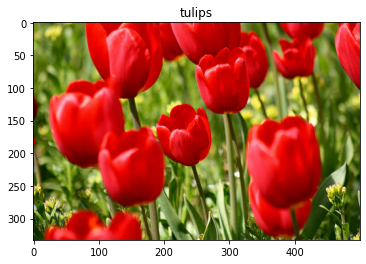

In [5]:
import matplotlib.pyplot as plt

get_label_name = metadata.features["label"].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

Iteración sobre el dataset como un diccionario
---

In [6]:
#
# Se carga nuevamente el dataset para este ejemplo
#
ds = tfds.load("tf_flowers", split="train")
ds = ds.take(1)

for example in ds:
    print(list(example.keys()))
    image = example["image"]
    label = example["label"]
    print(image.shape, label)

['image', 'label']
(333, 500, 3) tf.Tensor(2, shape=(), dtype=int64)


Iteración sobre el dataset como una tupla (as_supervised=True)
---

In [7]:
ds = tfds.load("tf_flowers", split="train", as_supervised=True)
ds = ds.take(1)

for image, label in ds:  # example is (image, label)
    print(image.shape, label)

(333, 500, 3) tf.Tensor(2, shape=(), dtype=int64)


Iteración sobre el dataset como NumPy
---

In [8]:
ds = tfds.load("tf_flowers", split="train", as_supervised=True)
ds = ds.take(1)

for image, label in tfds.as_numpy(ds):
    print(type(image), type(label), label)

<class 'numpy.ndarray'> <class 'numpy.int64'> 2


Iteración como un lote de datos
---

In [9]:
image, label = tfds.as_numpy(
    tfds.load(
        "tf_flowers",
        split="train",
        batch_size=-1,  # La función retorna todo el dataset
        as_supervised=True,
    )
)

print(type(image), image.shape)

<class 'numpy.ndarray'> (3670, 442, 1024, 3)


Visualización como un DataFrame
---

,image,label
0,,2 (tulips)
1,,3 (sunflowers)
2,,3 (sunflowers)
3,,4 (roses)

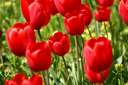
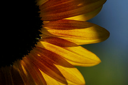
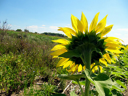
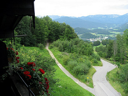

In [10]:
ds, info = tfds.load(
    "tf_flowers",
    split="train",
    with_info=True,
)

tfds.as_dataframe(ds.take(4), info)

Uso de show_examples()
---

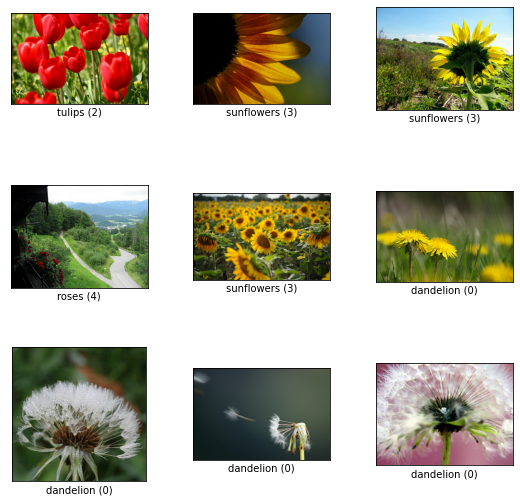

In [11]:
ds, info = tfds.load(
    "tf_flowers",
    split="train",
    with_info=True,
)

fig = tfds.show_examples(ds, info)

In [12]:
print(info)

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='/root/tensorflow_datasets/tf_flowers/3.0.1',
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)


In [13]:
info.features["label"].names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [14]:
#
# Particiones que tienen los datos
#
info.splits

{'train': <SplitInfo num_examples=3670, num_shards=2>}

Configuración del conjunto de datos para desempeño
----

In [15]:
#
# >>>> Código identico al ejemplo anterior >>>>
#
def configure_for_performance(ds):
    #
    # En la primera lectura, los datos pasan al cache; en las siguientes
    # lecturas los datos son leidos del cache
    #
    ds = ds.cache()

    #
    # Se seleccionan 1000 elementos del dataset. Luego, cuando un elemento es
    # seleccionado, es reemplazado por un elemento del segundo bloque de 1000
    # elementos, y así sucesivamente.
    #
    ds = ds.shuffle(buffer_size=1000)

    #
    # Combina elementos consecutivos del dataset en un lote del tamaño
    # especificado
    #
    ds = ds.batch(batch_size=32)

    #
    # Prepara el siguiente lote de elementos mientras el bloque actual esta
    # siendo procesado.
    #
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    return ds


train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)